In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Reshape, Conv2D, Conv1D
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import math
import numpy as np
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
TRAIN_DATA_DIR = '../data/for_generator/train'
VALIDATION_DATA_DIR = '../data/for_generator/val'
TEST_DATA_DIR = '../data/for_generator/test'
 
TRAIN_SAMPLES = 24000
VALIDATION_SAMPLES = 3000
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 16

In [3]:
def my_preprocess_input(image):
    image = np.array(image)
    converted_img = image/255
    return converted_img

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=my_preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
 
val_datagen = ImageDataGenerator(preprocessing_function=my_preprocess_input)

In [5]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    color_mode='grayscale',
                                                    class_mode='categorical')
 
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    shuffle=False,
    class_mode='categorical')

Found 24000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [6]:
initializer = tf.keras.initializers.HeNormal()


filter_num = 32
padding = 'valid'
bias = False
kernel_size = (3, 3)
model2 = models.Sequential([
  # input Nx17x4x3
  tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 1]),

  tf.keras.layers.Conv2D(filters = filter_num, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(filters = filter_num*2, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(filters = filter_num*4, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.2),
  # tf.keras.layers.Conv2D(filters = filter_num*8, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.ReLU(),

  # tf.keras.layers.Conv2D(filters = filter_num*8, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.ReLU(),
  
  # tf.keras.layers.Conv2D(filters = filter_num*8, kernel_size = kernel_size,  strides=1, padding='same', use_bias=bias,kernel_initializer=initializer),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.ReLU(),
  # tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  # tf.keras.layers.Dense(filter_num*8, kernel_initializer=initializer, activation = 'relu'),
  # tf.keras.layers.Dense(filter_num*4, kernel_initializer=initializer, activation = 'relu'),
  tf.keras.layers.Dense(2,kernel_initializer=initializer, activation = 'softmax'),
])
model2.summary()
# model2.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) adadelta
# optim =  tf.keras.optimizers.Nadam()
model2.compile(optimizer= 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

# model2.compile(optimizer= tf.keras.optimizers.Nadam(learning_rate=learning_rate),loss='mse', metrics=['mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      288       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18432     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     2

In [7]:
checkpoint_path = "./training_new_mp2/cp-{epoch:04d}.ckpt"   # 3
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                #  period=5,
                                                 monitor='val_accuracy',
                                                mode='max',
                                                 save_best_only=True)

In [8]:
history = model2.fit(
                train_generator,
                steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE, # number of updates
                epochs=30,
                validation_data=validation_generator,
                validation_steps=VALIDATION_SAMPLES // BATCH_SIZE,
                callbacks=[cp_callback ])

Epoch 1/30
1500/1500 [==============================] - ETA: 0s - loss: 0.9384 - accuracy: 0.6639
Epoch 1: val_accuracy improved from -inf to 0.53643, saving model to ./training_new_mp2\cp-0001.ckpt
1500/1500 [==============================] - 110s 72ms/step - loss: 0.9384 - accuracy: 0.6639 - val_loss: 1.1446 - val_accuracy: 0.5364
Epoch 2/30
1500/1500 [==============================] - ETA: 0s - loss: 0.5457 - accuracy: 0.7295
Epoch 2: val_accuracy improved from 0.53643 to 0.73563, saving model to ./training_new_mp2\cp-0002.ckpt
1500/1500 [==============================] - 106s 71ms/step - loss: 0.5457 - accuracy: 0.7295 - val_loss: 0.6089 - val_accuracy: 0.7356
Epoch 3/30
1500/1500 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.7441
Epoch 3: val_accuracy improved from 0.73563 to 0.73964, saving model to ./training_new_mp2\cp-0003.ckpt
1500/1500 [==============================] - 104s 70ms/step - loss: 0.5279 - accuracy: 0.7441 - val_loss: 0.5508 - val_accura

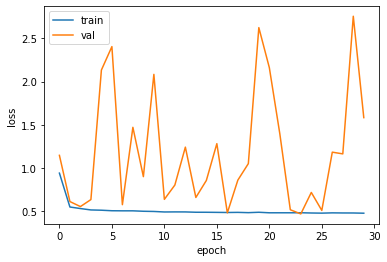

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

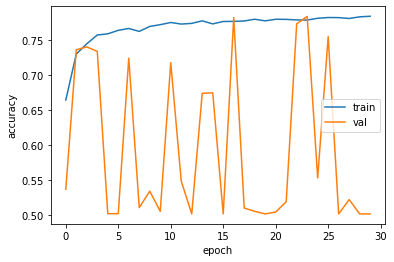

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()